In [1]:
# Original https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

import gpytorch
import pyro
import random
import torch
import torch.nn.functional as F
from utils import BI_LSE, accuracy, get_datasets, stable_logit_transform
from models import MLP
from copy import deepcopy
from scipy.special import expit
import seaborn as sns
from sklearn.inspection._plot.decision_boundary import _check_boundary_response_method

import os
os.makedirs('plots', exist_ok=True)

In [2]:
def get_BI(xs, models):
    preds = np.array([_check_boundary_response_method(m, 'auto')(xs) for m in models])
    # preds might be probabilities
    if len(preds.shape) == 3:
        logits = stable_logit_transform(preds[:,:,1])
    # or just logits
    else:
        logits = preds
        
    BIs = np.array([BI_LSE(zs, bound='lower') for zs in logits.T])
    return BIs

def get_models(clf, reps, n_samples=100):
    results = [[], [], []]
    for seed in range(reps):
        for ds_cnt, ((X_train, y_train), (X_test, y_test)) in enumerate(get_datasets(seed, n_samples=n_samples)):
            new_clf = deepcopy(clf)
            new_clf.fit(X_train, y_train)
            results[ds_cnt].append(new_clf)
    return results

def nn_models(n_models, n_samples=500, DE=False, **kwargs):
    results = [[], [], []]
    # if we want deep ensembles, we have to fix the dataset seed to get the same dataset
    seeds = [0 for _ in range(n_models)] if DE else range(n_models)
    
    for seed in seeds:
        for ds_cnt, ((X_train, y_train), (X_test, y_test)) in enumerate(get_datasets(seed, n_samples=n_samples)):
            model = MLP(**kwargs)
            model.fit(X_train, y_train)
            results[ds_cnt].append(model)
    return results

def BS_models(n_models, n_samples=500, DE=False, **kwargs):
    # bootstrapping
    results = [[], [], []]
    seeds = range(n_models)
    
    for ds_cnt, ((X_train, y_train), (X_test, y_test)) in enumerate(get_datasets(seed=0, n_samples=n_samples)):
        for seed in seeds:
            bs_ind = random.choices(range(n_samples), k=n_samples)
            bs_X = X_train[bs_ind]
            bs_y = y_train[bs_ind]
            model = MLP(**kwargs)
            model.fit(bs_X, bs_y)
            results[ds_cnt].append(model)
    return results

def kdl_models(n_models, n_samples=500, hidden_channels=[100,1], iters=None):
    results = [[], [], []]

    for seed in range(n_models):
        random.seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)
        for ds_cnt, ((X_train, y_train), (X_test, y_test)) in enumerate(get_datasets(seed, n_samples=n_samples)):
            num_feat = 5
            feat_extractor = MLP(hidden_channels=[100, num_feat]).model
            model = GPyTorchDKL(feature_extractor=feat_extractor, num_classes=2, num_features=num_feat, lr=1e-2, patience=25, frequency=2)
            model.fit(X_train, y_train)
            results[ds_cnt].append(model)
    return results

def vae_models(n_models, n_samples=500):
    results = [[], [], []]

    for seed in range(n_models):
        random.seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)
        pyro.set_rng_seed(seed)
        for ds_cnt, ((X_train, y_train), (X_test, y_test)) in enumerate(get_datasets(seed, n_samples=n_samples)):
            model = VAEClassifier(patience=5, z_dim=10, hidden_dim=40, lr=2e-4)
            model.fit(X_train, y_train)
            results[ds_cnt].append(model)
    return results

In [3]:
names = [
    "5 Nearest Neighbors",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "Naive Bayes",
]

classifiers = [
    KNeighborsClassifier(5),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=10),
    GradientBoostingClassifier(n_estimators=10),
    GaussianNB(),
]

n_ticks = 100
n_samples = 200
reps = 64

In [4]:
models = {name: get_models(func, reps=reps, n_samples=n_samples) for name, func in zip(names, classifiers)}
models['Neural Net'] = nn_models(n_models=reps, n_samples=n_samples, hidden_channels=[100, 1], frequency=2, patience=20)

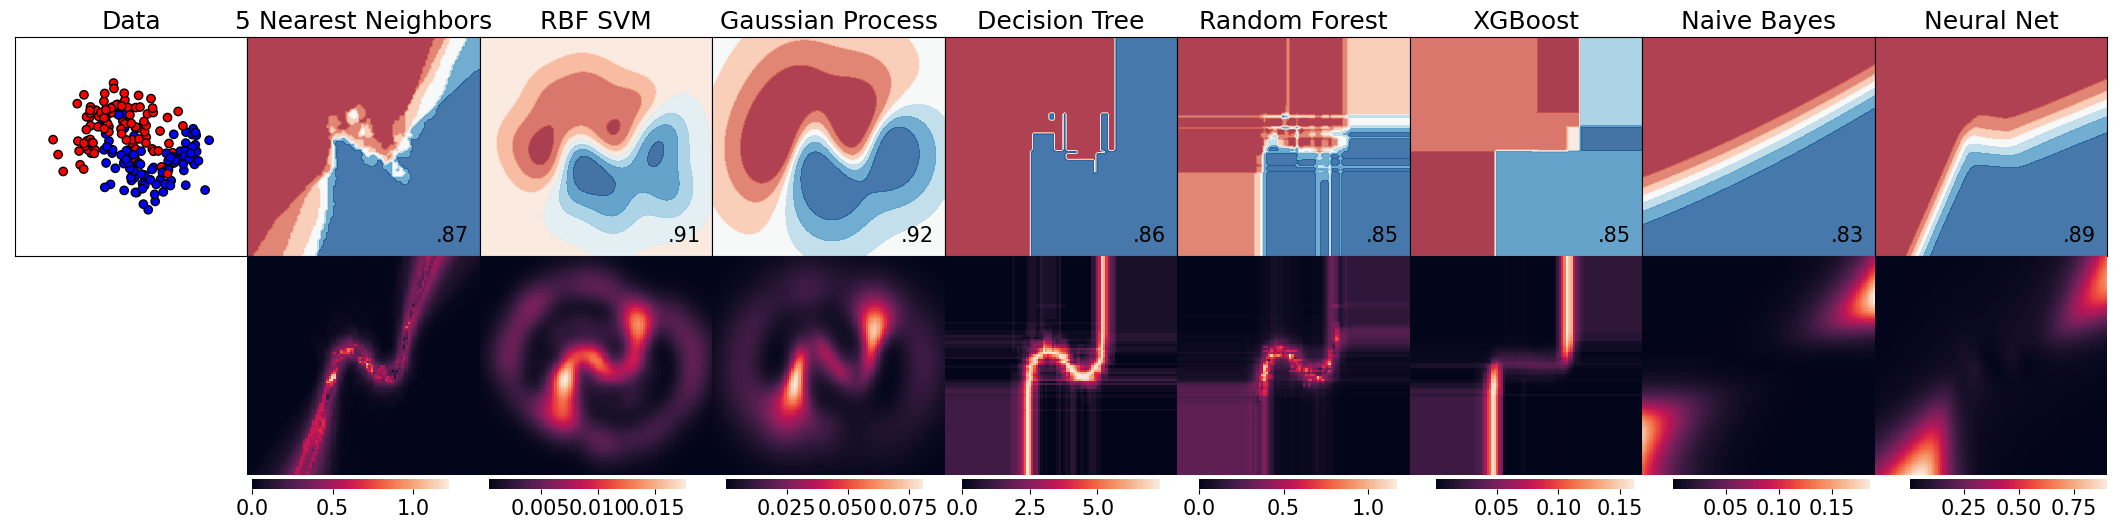

In [5]:
### Figure 5
ds_cnt = 0

### Figure 8
#ds_cnt = 1

### Figure 9
#ds_cnt = 2

datasets = get_datasets(1000, n_samples=n_samples)
offset = 1
zoom_out = False
rows = 2 + zoom_out

gridspec_kw={'height_ratios': [1, 1]}
cbar_kws = dict(use_gridspec=False, location="bottom")
plt.rcParams.update({'font.size': 15})
figure, axs = plt.subplots(rows, len(models) + offset, gridspec_kw=gridspec_kw, figsize=(27, 6+zoom_out*6))
i = 0
eps = 1
n_ticks = 100

ds = datasets[ds_cnt]
(X_train, y_train), (X_test, y_test) = ds

x_min, x_max = X_train[:, 0].min() - eps, X_train[:, 0].max() + eps
y_min, y_max = X_train[:, 1].min() - eps, X_train[:, 1].max() + eps

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = axs[0][i]
ax.set_title("Data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = axs[0][i]
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    x = np.linspace(x_min, x_max, n_ticks)
    y = np.linspace(y_min, y_max, n_ticks)
    xs, ys = np.meshgrid(x, y)
    X_grid = np.c_[xs.ravel(), ys.ravel()]

    if name == 'Neural Net':
        response = clf.predict(X_grid)
    else:
        response = _check_boundary_response_method(clf, 'auto')(X_grid)

    if len(response.shape) == 1:
        response = expit(response)
    else:
        response = response[:, 1]

    display = DecisionBoundaryDisplay(
        xx0=xs,
        xx1=ys,
        response=response.reshape(xs.shape),
    )
    display.plot(ax=ax, cmap=cm, alpha=0.8)

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(
        x_max - 0.3,
        y_min + 0.3,
        ("%.2f" % score).lstrip("0"),
        horizontalalignment="right",
    )
    i += 1
name = 'Neural Net'
ax = axs[0][i]
ax.set_title(name)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

torch.manual_seed(1000)
model = MLP(hidden_channels=[100, 1], test_size=0.3, weight_decay=0., patience=20, frequency=2)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
x = np.linspace(x_min, x_max, n_ticks)
y = np.linspace(y_min, y_max, n_ticks)
xs, ys = np.meshgrid(x, y)
X_grid = np.c_[xs.ravel(), ys.ravel()]

response = model.predict(X_grid)
response = expit(response)

display = DecisionBoundaryDisplay(
    xx0=xs,
    xx1=ys,
    response=response.reshape(xs.shape),
)
display.plot(ax=ax, cmap=cm, alpha=0.8)
ax.set_title(name)
ax.text(
    x_max - 0.3,
    y_min + 0.3,
    ("%.2f" % score).lstrip("0"),
    horizontalalignment="right",
)

i = 0
if False: #zoom_out:
    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = axs[1][i]
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
else:
    ax = axs[1][i]
    ax.axis('off')

i += 1

x_min, x_max = X_train[:, 0].min() - eps, X_train[:, 0].max() + eps
y_min, y_max = X_train[:, 1].min() - eps, X_train[:, 1].max() + eps

# iterate over classifiers
for name in models.keys():
    ax = axs[1][i]
    x = np.linspace(x_min, x_max, n_ticks)
    y = np.linspace(y_min, y_max, n_ticks)
    xs, ys = np.meshgrid(x, y)
    X_grid = np.c_[xs.ravel(), ys.ravel()]
    response = get_BI(X_grid, models[name][ds_cnt])
    response = response.reshape(xs.shape)

    with np.errstate(all='ignore'):
        sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

i = 0
if zoom_out:
    eps = 5
    x_min, x_max = X_train[:, 0].min() - eps, X_train[:, 0].max() + eps
    y_min, y_max = X_train[:, 1].min() - eps, X_train[:, 1].max() + eps

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = axs[2][i]
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name in models.keys():
        ax = axs[i]
        x = np.linspace(x_min, x_max, n_ticks)
        y = np.linspace(y_min, y_max, n_ticks)
        xs, ys = np.meshgrid(x, y)
        X_grid = np.c_[xs.ravel(), ys.ravel()]
        response = get_BI(X_grid, models[name][ds_cnt])
        response = response.reshape(xs.shape)

        with np.errstate(all='ignore'):
            sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

        ax.set_xticks(())
        ax.set_yticks(())
        i += 1

#plt.tight_layout()
plt.subplots_adjust(#left=0.1,
                    bottom=.17,
                    #right=0.9,
                    top=.9,
                    wspace=0.,
                    hspace=0.)
plt.savefig('plots/ext_classifier_ds_{}.png'.format(ds_cnt), bbox_inches='tight')
plt.show()

In [6]:
# train deep ensemble
de_models = nn_models(n_models=64, n_samples=n_samples, hidden_channels=[100, 1], frequency=2, patience=25, DE=True)

In [7]:
# train bootstrap ensemble
bs_models = BS_models(n_models=64, n_samples=n_samples, hidden_channels=[100, 1], frequency=2, patience=25)

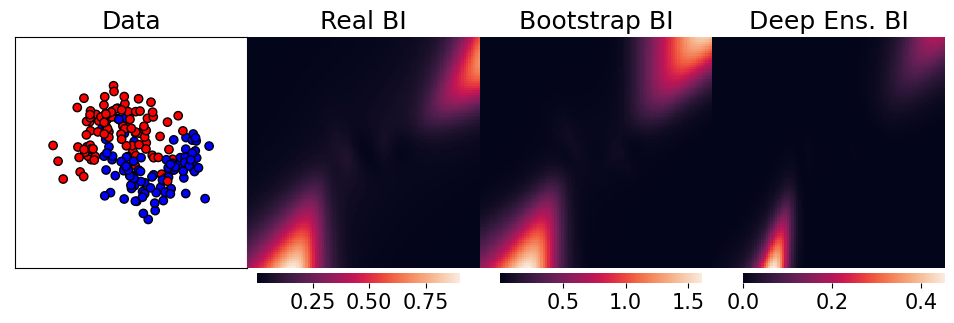

In [8]:
# Figure 6
datasets = get_datasets(1000, n_samples=n_samples)
zoom_out = False
ds_cnt = 0

cbar_kws = dict(use_gridspec=False, location="bottom")
plt.rcParams.update({'font.size': 15})
figure, axs = plt.subplots(1, 4, figsize=(12, 3.5))
eps = 1
n_ticks = 100

ds = datasets[ds_cnt]
(X_train, y_train), (X_test, y_test) = ds

x_min, x_max = X_train[:, 0].min() - eps, X_train[:, 0].max() + eps
y_min, y_max = X_train[:, 1].min() - eps, X_train[:, 1].max() + eps

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = axs[0]
ax.set_title("Data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

name = 'Neural Net'
x = np.linspace(x_min, x_max, n_ticks)
y = np.linspace(y_min, y_max, n_ticks)
xs, ys = np.meshgrid(x, y)
X_grid = np.c_[xs.ravel(), ys.ravel()]

# Real BI (approx over training set samples
response = get_BI(X_grid, models[name][ds_cnt])
response = response.reshape(xs.shape)

ax = axs[1]
with np.errstate(all='ignore'):
    sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

ax.set_title('Real BI')
ax.set_xticks(())
ax.set_yticks(())

# BI bootstrap
response = get_BI(X_grid, bs_models[ds_cnt])
response = response.reshape(xs.shape)

ax = axs[2]
with np.errstate(all='ignore'):
    sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

ax.set_title('Bootstrap BI')
ax.set_xticks(())
ax.set_yticks(())

# BI deep ensembles
response = get_BI(X_grid, de_models[ds_cnt])
response = response.reshape(xs.shape)

ax = axs[3]
with np.errstate(all='ignore'):
    sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

ax.set_title('Deep Ens. BI')
ax.set_xticks(())
ax.set_yticks(())

#plt.tight_layout()
plt.subplots_adjust(#left=0.1,
                    bottom=.24,
                    #right=0.9,
                    top=.9,
                    wspace=0.,
                    hspace=0.)
plt.savefig('plots/BI_approx_ds_{}.png'.format(ds_cnt), bbox_inches='tight')
plt.show()

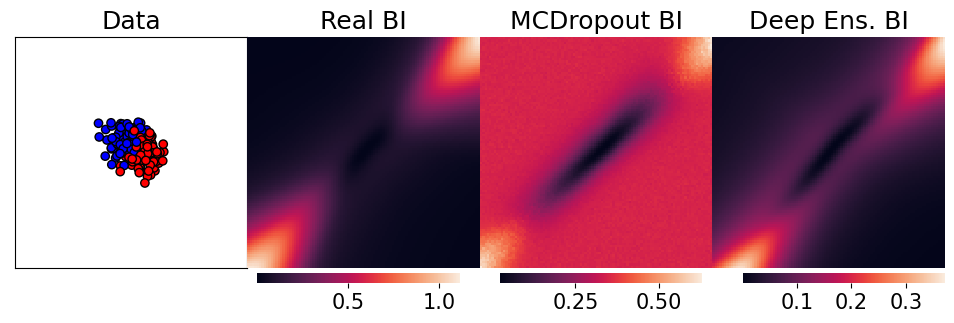

In [9]:
torch.manual_seed(123)
datasets = get_datasets(1000, n_samples=n_samples)
zoom_out = False
ds_cnt = 2

cbar_kws = dict(use_gridspec=False, location="bottom")
plt.rcParams.update({'font.size': 15})
figure, axs = plt.subplots(1, 4, figsize=(12, 3.5))
eps = 5
n_ticks = 100

ds = datasets[ds_cnt]
(X_train, y_train), (X_test, y_test) = ds

x_min, x_max = X_train[:, 0].min() - eps, X_train[:, 0].max() + eps
y_min, y_max = X_train[:, 1].min() - eps, X_train[:, 1].max() + eps

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = axs[0]
ax.set_title("Data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

name = 'Neural Net'
x = np.linspace(x_min, x_max, n_ticks)
y = np.linspace(y_min, y_max, n_ticks)
xs, ys = np.meshgrid(x, y)
X_grid = np.c_[xs.ravel(), ys.ravel()]

# Real BI (approx over training set samples
response = get_BI(X_grid, models[name][ds_cnt])
response = response.reshape(xs.shape)

ax = axs[1]
with np.errstate(all='ignore'):
    sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

ax.set_title('Real BI')
ax.set_xticks(())
ax.set_yticks(())

# BI mc dropout
response = de_models[ds_cnt][2].estimate_dropout_BI(X_grid, n_ens=5000)
response = response.reshape(xs.shape)

ax = axs[2]
with np.errstate(all='ignore'):
    sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

ax.set_title('MCDropout BI')
ax.set_xticks(())
ax.set_yticks(())

# BI deep ensembles
response = get_BI(X_grid, de_models[ds_cnt])
response = response.reshape(xs.shape)

ax = axs[3]
with np.errstate(all='ignore'):
    sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

ax.set_title('Deep Ens. BI')
ax.set_xticks(())
ax.set_yticks(())

#plt.tight_layout()
plt.subplots_adjust(#left=0.1,
                    bottom=.24,
                    #right=0.9,
                    top=.9,
                    wspace=0.,
                    hspace=0.)
plt.savefig('plots/BI_approx_ds_{}_zoomout.png'.format(ds_cnt), bbox_inches='tight')
plt.show()

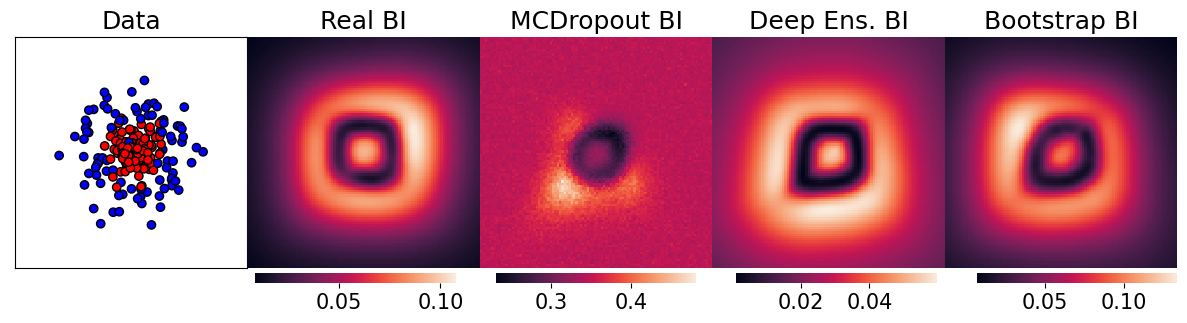

In [10]:
# Figure 10
# a)
ds_cnt = 1

# b)
#ds_cnt = 2

datasets = get_datasets(1000, n_samples=n_samples)
zoom_out = False

cbar_kws = dict(use_gridspec=False, location="bottom")
plt.rcParams.update({'font.size': 15})
figure, axs = plt.subplots(1, 5, figsize=(15, 3.5))
eps = 1
n_ticks = 100

ds = datasets[ds_cnt]
(X_train, y_train), (X_test, y_test) = ds

x_min, x_max = X_train[:, 0].min() - eps, X_train[:, 0].max() + eps
y_min, y_max = X_train[:, 1].min() - eps, X_train[:, 1].max() + eps

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = axs[0]
ax.set_title("Data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

name = 'Neural Net'
x = np.linspace(x_min, x_max, n_ticks)
y = np.linspace(y_min, y_max, n_ticks)
xs, ys = np.meshgrid(x, y)
X_grid = np.c_[xs.ravel(), ys.ravel()]

# Real BI (approx over training set samples
response = get_BI(X_grid, models[name][ds_cnt])
response = response.reshape(xs.shape)

ax = axs[1]
with np.errstate(all='ignore'):
    sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

ax.set_title('Real BI')
ax.set_xticks(())
ax.set_yticks(())

# BI mc dropout
response = de_models[ds_cnt][2].estimate_dropout_BI(X_grid, n_ens=5000)
response = response.reshape(xs.shape)

ax = axs[2]
with np.errstate(all='ignore'):
    sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

ax.set_title('MCDropout BI')
ax.set_xticks(())
ax.set_yticks(())

# BI deep ensembles
response = get_BI(X_grid, de_models[ds_cnt])
response = response.reshape(xs.shape)

ax = axs[3]
with np.errstate(all='ignore'):
    sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

ax.set_title('Deep Ens. BI')
ax.set_xticks(())
ax.set_yticks(())

# BI bootstrap
response = get_BI(X_grid, bs_models[ds_cnt])
response = response.reshape(xs.shape)

ax = axs[4]
with np.errstate(all='ignore'):
    sns.heatmap(response, ax=ax, cbar_kws=cbar_kws).invert_yaxis()

ax.set_title('Bootstrap BI')
ax.set_xticks(())
ax.set_yticks(())

#plt.tight_layout()
plt.subplots_adjust(#left=0.1,
                    bottom=.24,
                    #right=0.9,
                    top=.9,
                    wspace=0.,
                    hspace=0.)
plt.savefig('plots/BI_approx_ds_{}_ext.png'.format(ds_cnt), bbox_inches='tight')
plt.show()